## Flight delay data preprocessing and analysis

**1. Data Downloading**

In [5]:
import kagglehub

path = kagglehub.dataset_download("hrishitpatil/flight-data-2024")

print("Downloaded to:", path)


Resuming download from 30408704 bytes (253137150 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/hrishitpatil/flight-data-2024?dataset_version_number=2 (30408704/283545854) bytes left.


100%|██████████| 270M/270M [00:33<00:00, 7.59MB/s] 

Extracting files...


Downloaded to: /home/adam/.cache/kagglehub/datasets/hrishitpatil/flight-data-2024/versions/2


In [ ]:
from pathlib import Path
import shutil

data_folder = Path('../data')
data_folder.mkdir(exist_ok=True)

for f in Path(path).glob('*'):
    shutil.copy(f, data_folder / f.name)


In [10]:
import pandas as pd

df = pd.read_csv("../data/flight_data_2024.csv")

/tmp/ipykernel_4257/1157875057.py:3: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/flight_data_2024.csv")


In [11]:
df.head()

,year,month,day_of_month,day_of_week,fl_date,op_unique_carrier,op_carrier_fl_num,origin,origin_city_name,origin_state_nm,...,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2024,1,1,1,2024-01-01,9E,4814.0,JFK,"New York, NY",New York,...,0,136.0,122.0,84.0,509.0,0,0,0,0,0
1,2024,1,1,1,2024-01-01,9E,4815.0,MSP,"Minneapolis, MN",Minnesota,...,0,130.0,114.0,88.0,622.0,0,0,0,0,0
2,2024,1,1,1,2024-01-01,9E,4817.0,JFK,"New York, NY",New York,...,0,106.0,90.0,61.0,288.0,0,0,0,0,0
3,2024,1,1,1,2024-01-01,9E,4817.0,RIC,"Richmond, VA",Virginia,...,0,111.0,76.0,51.0,288.0,0,0,0,0,0
4,2024,1,1,1,2024-01-01,9E,4818.0,DTW,"Detroit, MI",Michigan,...,0,79.0,70.0,45.0,237.0,0,0,0,0,0


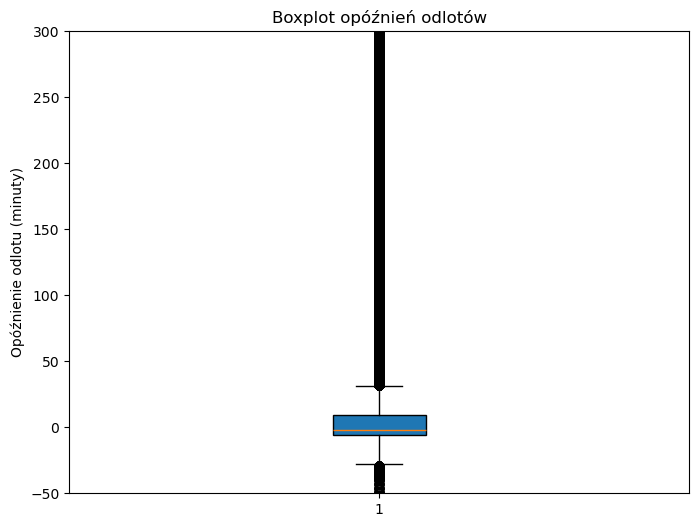

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,6))
plt.boxplot(df['arr_delay'].dropna(), vert=True, patch_artist=True)
plt.ylabel("Arrival delay minutes")
plt.title("Boxplot of arrival delays")
plt.ylim(-50, 300)
plt.show()
